## How to Win a Data Science Competition
### Final Project
Note: The EDA it's in another IPython called Final_Project_EDA.
<hr>
<h3>Criteria</h3>

Clarity
- The clear step-by-step instruction on how to produce the final submit file is provided
- Code has comments where it is needed and meaningful function names

Feature preprocessing and generation with respect to models
- Several simple features are generated
- For non-tree-based models preprocessing is used or the absence of it is explained

Feature extraction from text and images
- Features from text are extracted
- Special preprocessings for text are utilized (TF-IDF, stemming, levenshtening...)

EDA
- Several interesting observations about data are discovered and explained
- Target distribution is visualized, time trend is assessed

Validation
- Type of train/test split is identified and used for validation
- Type of public/private split is identified

Data leakages
- Data is investigated for data leakages and investigation process is described
- Found data leakages are utilized
Metrics optimization
- Correct metric is optimized

Advanced Features I: mean encodings
- Mean-encoding is applied
- Mean-encoding is set up correctly, i.e. KFold or expanding scheme are utilized correctly

Advanced Features II
- At least one feature from this topic is introduced

Hyperparameter tuning
- Parameters of models are roughly optimal

Ensembles
- Ensembling is utilized (linear combination counts)
- Validation with ensembling scheme is set up correctly, i.e. KFold or Holdout is utilized
- Models from different classes are utilized (at least two from the following: KNN, linear models, RF, GBDT, NN)

### Loading the data

In [2]:
# imports
import warnings
warnings.filterwarnings("ignore")
from itertools import product
import gc
import numpy as np
import pandas as pd
import lightgbm as lgb
import utils
import shap
import matplotlib.pyplot as plt
from itertools import product
from copy import deepcopy
from sklearn.externals import joblib
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [5]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv').set_index('ID')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [9]:
train['sales'] = train['item_cnt_day']*train['item_price']

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
sales             float64
dtypes: float64(3), int64(3), object(1)
memory usage: 156.8+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 2 columns):
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(2)
memory usage: 4.9 MB


In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [14]:
utils.print_df_info(test)

---------------------------------
        Rows: 214200
        Columns: 2
        NaN Values: 0
        Missing Values: 0
        Duplicated Rows: 0
---------------------------------


In [15]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


#### Extracting Features from Item Names

Since we are dealing with several Russian words we need some ideia of what is those words and split them into more categorical features.

In [16]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

items = items.drop(['item_name'], axis=1)

Yeah, now we have a more precise information about item_name, let's try to process some text with TF-IDF, i saw some tutorials for this, so it may have some better ways to manipulate.

### TF-IDF Preprocessing

Here i'm using utils.py that i created just to use some generalized functions, so the tfidf_preprocess will return us the len of each string of the column and a word count, which we will use as features to create our model in some next steps.

In [17]:
%%time
items_aux = pd.read_csv('items.csv')
item_categories_aux = pd.read_csv('item_categories.csv')
shops_aux = pd.read_csv('shops.csv')
items_aux = utils.tfidf_preprocess(items_aux, 'item_name', n_features = 25)
shops_aux = utils.tfidf_preprocess(shops_aux, 'shop_name', n_features = 25)

Mem. usage decreased to  1.35 Mb (73.3% reduction)
Mem. usage decreased to  0.00 Mb (73.0% reduction)
CPU times: user 616 ms, sys: 142 ms, total: 758 ms
Wall time: 777 ms


### Merging Train set and Test set for Feature Extraction

The main idea here is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data

In [18]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [19]:
train_aux = []
cols = ['date_block_num','shop_id','item_id']
for block_num in range(34):
    temp = train[train.date_block_num==block_num]
    train_aux.append(np.array(list(product([block_num], temp['shop_id'].unique(), temp['item_id'].unique()))))
    
train_aux = pd.DataFrame(np.vstack(train_aux), columns=cols)
train_aux['date_block_num'] = train_aux['date_block_num'].astype(np.int8)
train_aux['shop_id'] = train_aux['shop_id'].astype(np.int8)
train_aux['item_id'] = train_aux['item_id'].astype(np.int16)
train_aux = train_aux.sort_values(cols)
train_aux.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [20]:
# Merge item count month
item_cnt_month = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum'})
item_cnt_month.columns = ['item_cnt_month']
train_aux = pd.merge(train_aux, item_cnt_month, on=cols, how='left')
train_aux['item_cnt_month'] = (train_aux['item_cnt_month']
                                .fillna(0)
                                .clip(0,20))
train_aux.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


In [6]:
# Merge test into matrix
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

train_aux_2 = pd.concat([train_aux, test], ignore_index=True, sort=False, keys=cols)
train_aux_2.fillna(0, inplace=True)

In [22]:
train_aux_2 = utils.downcast_dtypes(train_aux_2)

Mem. usage decreased to 63.68 Mb (50.0% reduction)


In [23]:
train_aux_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128050 entries, 0 to 11128049
Data columns (total 4 columns):
date_block_num    int8
shop_id           int8
item_id           int16
item_cnt_month    float16
dtypes: float16(1), int16(1), int8(2)
memory usage: 63.7 MB


In [24]:
gc.collect();

In [25]:
full_train = pd.merge(train_aux_2, shops, on = ['shop_id'], how = 'left')
full_train = pd.merge(full_train, items, on = ['item_id'], how = 'left')
full_train = pd.merge(full_train, item_categories, on = ['item_category_id'], how = 'left')
full_train = utils.downcast_dtypes(full_train)

Mem. usage decreased to 191.03 Mb (60.9% reduction)


In [26]:
del train_aux_2
del train_aux
del train
del items
del item_categories
del item_cnt_month

### Creating Lag Features
Now let's create some lag features, for those who don't know what are lag features i'm gonna leave an example below:<br>
- e.g. We have a value at time t, so the past values are known as lags, so t-1 is lag 1, t-2 is lag 2, etc.

In [27]:
gc.collect();

In [28]:
gc.collect();
full_train = utils.lag_feature(full_train, [1,2,3,6,12], 'item_cnt_month')
full_train = utils.downcast_dtypes(full_train)
gc.collect();

Lag: 1 for item_cnt_month
Lag: 2 for item_cnt_month
Lag: 3 for item_cnt_month
Lag: 6 for item_cnt_month
Lag: 12 for item_cnt_month

Mem. usage decreased to 297.15 Mb (0.0% reduction)


In [29]:
# Note: I'm using a print for know where column it's actually lagging so i can be able to re-do if needed
df_after_lag = utils.create_lagged_features(full_train)

1.


Lag: 1 for date_avg_item_cnt

Mem. usage decreased to 318.38 Mb (0.0% reduction)
2.


Lag: 1 for date_item_avg_item_cnt
Lag: 2 for date_item_avg_item_cnt
Lag: 3 for date_item_avg_item_cnt
Lag: 6 for date_item_avg_item_cnt
Lag: 12 for date_item_avg_item_cnt

Mem. usage decreased to 424.50 Mb (0.0% reduction)
3.


Lag: 1 for date_shop_avg_item_cnt
Lag: 2 for date_shop_avg_item_cnt
Lag: 3 for date_shop_avg_item_cnt
Lag: 6 for date_shop_avg_item_cnt
Lag: 12 for date_shop_avg_item_cnt

Mem. usage decreased to 530.63 Mb (0.0% reduction)
4.


Lag: 1 for date_category_avg_item_cnt

Mem. usage decreased to 551.85 Mb (0.0% reduction)
5.


Lag: 1 for date_shop_category_avg_item_cnt

Mem. usage decreased to 573.08 Mb (0.0% reduction)
6.


Lag: 1 for date_shop_type_avg_item_cnt

Mem. usage decreased to 594.30 Mb (0.0% reduction)
7.


Lag: 1 for date_type_avg_item_cnt

Mem. usage decreased to 615.53 Mb (0.0% reduction)
8.


Lag: 1 for date_city_avg_item_cnt

Mem. usage decreased to 636.75 Mb (0.0% reduction)
9.


Lag: 1 for date_shop_subtype_avg_item_cnt

Mem. usage decreased to 657.98 Mb (0.0% reduction)
10.


Lag: 1 for date_item_city_avg_item_cnt

Mem. usage decreased to 679.20 Mb (0.0% reduction)
11.


Lag: 1 for date_subtype_avg_item_cnt

Mem. usage decreased to 700.43 Mb (0.0% reduction)


In [30]:
df_after_lag = df_after_lag[df_after_lag['date_block_num'] > 11]

# Filling NaN's for Lag columns which contain our item_cnt_month
for col in df_after_lag.columns:
    if ('_lag_' in col) & (df_after_lag[col].isnull().any()):
        if ('item_cnt' in col):
            df_after_lag[col] = df_after_lag[col].fillna(0)

df = pd.merge(df_after_lag, items_aux, on = ['item_id'], how = 'left')
df = pd.merge(df, shops_aux, on = ['shop_id'], how = 'left')

In [31]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id_x,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,12,2,27,0.0,0,19,5,10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.498535,0.0,0.0,0.0
1,12,2,30,0.0,0,40,11,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.498535,0.0,0.0,0.0
2,12,2,31,0.0,0,37,11,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.498535,0.0,0.0,0.0
3,12,2,32,1.0,0,40,11,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.498535,0.0,0.0,0.0
4,12,2,33,1.0,0,37,11,1,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.498535,0.0,0.0,0.0


In [32]:
df = df.drop(['item_name', 'item_name_len', 'item_name_word_count', 'item_category_id_y',
         'shop_name', 'shop_name_len', 'shop_name_word_count'], axis=1)

In [33]:
categorical_features = ['shop_id', 'item_id', 'city_code', 'item_category_id_x', 'type_code', 'subtype_code']

In [34]:
sorted(list(df.columns))

['city_code',
 'date_avg_item_cnt_lag_1',
 'date_block_num',
 'date_category_avg_item_cnt_lag_1',
 'date_city_avg_item_cnt_lag_1',
 'date_item_avg_item_cnt_lag_1',
 'date_item_avg_item_cnt_lag_12',
 'date_item_avg_item_cnt_lag_2',
 'date_item_avg_item_cnt_lag_3',
 'date_item_avg_item_cnt_lag_6',
 'date_item_city_avg_item_cnt_lag_1',
 'date_shop_avg_item_cnt_lag_1',
 'date_shop_avg_item_cnt_lag_12',
 'date_shop_avg_item_cnt_lag_2',
 'date_shop_avg_item_cnt_lag_3',
 'date_shop_avg_item_cnt_lag_6',
 'date_shop_category_avg_item_cnt_lag_1',
 'date_shop_subtype_avg_item_cnt_lag_1',
 'date_shop_type_avg_item_cnt_lag_1',
 'date_subtype_avg_item_cnt_lag_1',
 'date_type_avg_item_cnt_lag_1',
 'item_category_id_x',
 'item_cnt_month',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_12',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_cnt_month_lag_6',
 'item_id',
 'item_name_tfidf_0',
 'item_name_tfidf_1',
 'item_name_tfidf_10',
 'item_name_tfidf_11',
 'item_name_tfidf_12',
 'item_name_tfidf_13',
 'item_name_tfidf_14',
 'item_name_tfidf_15',
 'item_name_tfidf_16',
 'item_name_tfidf_17',
 'item_name_tfidf_18',
 'item_name_tfidf_19',
 'item_name_tfidf_2',
 'item_name_tfidf_20',
 'item_name_tfidf_21',
 'item_name_tfidf_22',
 'item_name_tfidf_23',
 'item_name_tfidf_24',
 'item_name_tfidf_3',
 'item_name_tfidf_4',
 'item_name_tfidf_5',
 'item_name_tfidf_6',
 'item_name_tfidf_7',
 'item_name_tfidf_8',
 'item_name_tfidf_9',
 'shop_id',
 'shop_name_tfidf_0',
 'shop_name_tfidf_1',
 'shop_name_tfidf_10',
 'shop_name_tfidf_11',
 'shop_name_tfidf_12',
 'shop_name_tfidf_13',
 'shop_name_tfidf_14',
 'shop_name_tfidf_15',
 'shop_name_tfidf_16',
 'shop_name_tfidf_17',
 'shop_name_tfidf_18',
 'shop_name_tfidf_19',
 'shop_name_tfidf_2',
 'shop_name_tfidf_20',
 'shop_name_tfidf_21',
 'shop_name_tfidf_22',
 'shop_name_tfidf_23',
 'shop_name_tfidf_24',
 'shop_name_tfidf_3',
 'shop_name_tfidf_4',
 'shop_name_tfidf_5',
 'shop_name_tfidf_6',
 'shop_name_tfidf_7',
 'shop_name_tfidf_8',
 'shop_name_tfidf_9',
 'subtype_code',
 'type_code']

### Mean Encoding

In Mean Encoding we take the number of labels into account along with the target variable to encode the labels into machine comprehensible values. Mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value.

In [35]:
df1 = deepcopy(df)
df1 = df1.reset_index()

cv = KFold(n_splits=5, shuffle=False)
new_features = []

check = False
for train_idx, valid_idx in cv.split(df1):
    
    # Train/validation split
    X_train, X_valid = df1.iloc[train_idx,:], df1.iloc[valid_idx,:]
    
    # Mean encoding
    for col in categorical_features:
        means = X_valid[col].map(X_train.groupby(col).item_cnt_month.mean())
        col_new = col+'_target_enc'
        X_valid[col_new] = means
        
        # Results
        df1.loc[valid_idx, col_new] = X_valid
        
        # Store new columns
        if check==False:
            new_features.append(col_new)
    
    check = True

In [36]:
prior = np.mean(df1['item_cnt_month'].values)
df1[new_features] = df1[new_features].fillna(prior)
df1.head()

,index,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id_x,type_code,subtype_code,item_cnt_month_lag_1,...,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24,shop_id_target_enc,item_id_target_enc,city_code_target_enc,item_category_id_x_target_enc,type_code_target_enc,subtype_code_target_enc
0,0,12,2,27,0.0,0,19,5,10,0.0,...,0.498535,0.0,0.0,0.0,0.141602,0.040802,0.141602,0.550781,0.570312,0.511230
1,1,12,2,30,0.0,0,40,11,4,0.0,...,0.498535,0.0,0.0,0.0,0.141602,0.186646,0.141602,0.230835,0.197021,0.230835
2,2,12,2,31,0.0,0,37,11,1,0.0,...,0.498535,0.0,0.0,0.0,0.141602,0.315186,0.141602,0.157837,0.197021,0.158691
3,3,12,2,32,1.0,0,40,11,4,0.0,...,0.498535,0.0,0.0,0.0,0.141602,0.575195,0.141602,0.230835,0.197021,0.230835
4,4,12,2,33,1.0,0,37,11,1,1.0,...,0.498535,0.0,0.0,0.0,0.141602,0.336426,0.141602,0.157837,0.197021,0.158691


In [37]:
df1 = df1.drop(categorical_features + ['index'], axis = 1)
categorical_features = deepcopy(new_features)

In [38]:
sorted(list(df1.columns))

['city_code_target_enc',
 'date_avg_item_cnt_lag_1',
 'date_block_num',
 'date_category_avg_item_cnt_lag_1',
 'date_city_avg_item_cnt_lag_1',
 'date_item_avg_item_cnt_lag_1',
 'date_item_avg_item_cnt_lag_12',
 'date_item_avg_item_cnt_lag_2',
 'date_item_avg_item_cnt_lag_3',
 'date_item_avg_item_cnt_lag_6',
 'date_item_city_avg_item_cnt_lag_1',
 'date_shop_avg_item_cnt_lag_1',
 'date_shop_avg_item_cnt_lag_12',
 'date_shop_avg_item_cnt_lag_2',
 'date_shop_avg_item_cnt_lag_3',
 'date_shop_avg_item_cnt_lag_6',
 'date_shop_category_avg_item_cnt_lag_1',
 'date_shop_subtype_avg_item_cnt_lag_1',
 'date_shop_type_avg_item_cnt_lag_1',
 'date_subtype_avg_item_cnt_lag_1',
 'date_type_avg_item_cnt_lag_1',
 'item_category_id_x_target_enc',
 'item_cnt_month',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_12',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_cnt_month_lag_6',
 'item_id_target_enc',
 'item_name_tfidf_0',
 'item_name_tfidf_1',
 'item_name_tfidf_10',
 'item_name_tfidf_11',
 'item_name_tfidf_12',
 'item_name_tfidf_13',
 'item_name_tfidf_14',
 'item_name_tfidf_15',
 'item_name_tfidf_16',
 'item_name_tfidf_17',
 'item_name_tfidf_18',
 'item_name_tfidf_19',
 'item_name_tfidf_2',
 'item_name_tfidf_20',
 'item_name_tfidf_21',
 'item_name_tfidf_22',
 'item_name_tfidf_23',
 'item_name_tfidf_24',
 'item_name_tfidf_3',
 'item_name_tfidf_4',
 'item_name_tfidf_5',
 'item_name_tfidf_6',
 'item_name_tfidf_7',
 'item_name_tfidf_8',
 'item_name_tfidf_9',
 'shop_id_target_enc',
 'shop_name_tfidf_0',
 'shop_name_tfidf_1',
 'shop_name_tfidf_10',
 'shop_name_tfidf_11',
 'shop_name_tfidf_12',
 'shop_name_tfidf_13',
 'shop_name_tfidf_14',
 'shop_name_tfidf_15',
 'shop_name_tfidf_16',
 'shop_name_tfidf_17',
 'shop_name_tfidf_18',
 'shop_name_tfidf_19',
 'shop_name_tfidf_2',
 'shop_name_tfidf_20',
 'shop_name_tfidf_21',
 'shop_name_tfidf_22',
 'shop_name_tfidf_23',
 'shop_name_tfidf_24',
 'shop_name_tfidf_3',
 'shop_name_tfidf_4',
 'shop_name_tfidf_5',
 'shop_name_tfidf_6',
 'shop_name_tfidf_7',
 'shop_name_tfidf_8',
 'shop_name_tfidf_9',
 'subtype_code_target_enc',
 'type_code_target_enc']

In [39]:
joblib.dump(categorical_features, "cat_features.pkl", compress = "lz4")

['cat_features.pkl']

In [33]:
joblib.dump(df1, "data.pkl", compress = "lz4")

['data.pkl']

Now we have a checkpoint, so let's build our model and see if our efforts were for a good reason haha.

### Building Model
So, at first sight i tried to implement a walk-forward cross-validation but i failed hahaha, but it worths the experience, now i'll try a more simple scheme called holdout, I'll keep January 2013 to September 2015 for training, October 2015 for validation and November 2015 for testing. Let's get it!!

In [3]:
df1 = joblib.load("data.pkl")

In [4]:
categorical_features = joblib.load("cat_features.pkl")

In [7]:
data = deepcopy(df1)

X_train = data[data['date_block_num']<33].drop(['item_cnt_month'], axis=1)
y_train = data[data['date_block_num']<33]['item_cnt_month']

X_val = data[data['date_block_num']==33].drop(['item_cnt_month'], axis=1)
y_val = data[data['date_block_num']==33]['item_cnt_month']

X_test =  data[data['date_block_num']==34].drop(['item_cnt_month'], axis=1)

I'll use LightGBM Regressor since i have some problems to install XGBoost on my laptop, if anyone could help me with that i'll be grateful.

In [8]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_val, y_val)

params = {
    'learning_rate': 0.01,
     'max_depth': 7,
     'min_data_in_leaf': 5,
     'n_estimators': 500,
     'num_leaves': 75,
     'objective': 'mse',
     'random_state': 42,
     'n_jobs': -1,
}

model_lgbm = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_valid,
                       early_stopping_rounds=200, categorical_feature=categorical_features,
                       verbose_eval=50)

Training until validation scores don't improve for 200 rounds
[50]	valid_0's l2: 1.05034
[100]	valid_0's l2: 0.968757
[150]	valid_0's l2: 0.933547
[200]	valid_0's l2: 0.921956
[250]	valid_0's l2: 0.914976
[300]	valid_0's l2: 0.912097
[350]	valid_0's l2: 0.914385
[400]	valid_0's l2: 0.916155
[450]	valid_0's l2: 0.915565
[500]	valid_0's l2: 0.915864
Did not meet early stopping. Best iteration is:
[302]	valid_0's l2: 0.911935


In [9]:
lgbm_pred = model_lgbm.predict(X_val)
print(f'RMSE LightGBM: {round(np.sqrt(mean_squared_error(y_val, lgbm_pred)),4)}')

RMSE LightGBM: 0.955


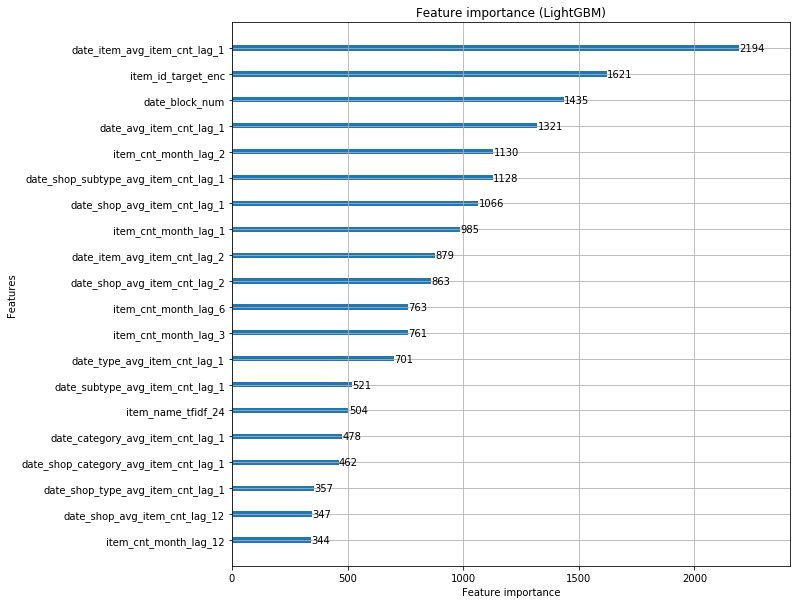

In [10]:
lgb.plot_importance(model_lgbm, max_num_features=20, figsize=(10,10), title="Feature importance (LightGBM)")
plt.show()

In [11]:
joblib.dump(model_lgbm, 'model_lgbm.pkl')

['model_lgbm.pkl']

Yeah, we rock it, our features look's good, we had a good RMSE of almost 0.95. But let's continue it, what if we try a Linear Regression? We could use it for ensembling in the future :D.

In [12]:
# For a better regression we should standardize our data
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

In [13]:
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train_std, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
print(np.sqrt(mean_squared_error(y_val, model_linreg.predict(X_val_std))))

0.9692220426681442


In [53]:
joblib.dump(model_linreg, 'model_linreg.pkl')

['model_linreg.pkl']

Wow, as we can see a simple Linear Regression can give us awesome results, if we put ourselfs into company's position we probably would invest to use a less complicated model such as Linear Regression than LightGBM since gave us similar results, it's more scalable and stable than LightGBM. Now that we have two cool models, let's ensemble it!!

### Ensembling and Creating our Submission

Creating 1st generation features

In [15]:
pred_lgb = model_lgbm.predict(X_val)
pred_lr = model_linreg.predict(X_val_std)
X_val_level2 = np.c_[pred_lr, pred_lgb] 

Creating 2nd generation features

In [16]:
X_train = data[data['date_block_num']<=32].drop(['item_cnt_month'], axis=1)
y_train = data[data['date_block_num']<=32]['item_cnt_month']
X_val = data[data['date_block_num']==33].drop(['item_cnt_month'], axis=1)
y_val = data[data['date_block_num']==33]['item_cnt_month']

In [17]:
dates = data['date_block_num']
last_block = dates.max()
print(f"Test date_block_num is {last_block}")
dates_train = dates[dates < last_block]
dates_test  = dates[dates == last_block]
periods = [26, 27, 28, 29, 30, 31, 32]

Test date_block_num is 34


In [18]:
dates_train_level2 = dates_train[dates_train.isin(periods)]
y_train_level2 = y_train[dates_train.isin(periods)]
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

In [19]:
for cur_block_num in periods:
    
    print('cur_block_num:', cur_block_num)
    
    # 1. Split 'X_train' into parts
    x = data[data['date_block_num']<cur_block_num].drop(['item_cnt_month'], axis=1)
    y = data[data['date_block_num']<cur_block_num]['item_cnt_month'].values
    x_test =  data[data['date_block_num']==cur_block_num].drop(['item_cnt_month'], axis=1)
    y_test =  data[data['date_block_num']==cur_block_num]['item_cnt_month'].values
    
    # 2. Fit linear regression
    print('Linear regression')
    lr = LinearRegression(fit_intercept=True, normalize=True)
    scaler = StandardScaler().fit(x)
    x_std = scaler.transform(x)
    x_test_std = scaler.transform(x_test)
    lr.fit(x_std, y)
    y_test_linreg = lr.predict(x_test_std)
    
    # 3. Fit LightGBM and put predictions
    print('LightGBM')
    n_trees = 500
    lgb_train = lgb.Dataset(x, y)
    lgb_valid = lgb.Dataset(x_test, y_test)
    model_lgbm = lgb.train(params, lgb_train, num_boost_round=n_trees,
                           valid_sets=lgb_valid, early_stopping_rounds=50,
                           verbose_eval=50)
    y_test_lgb = model_lgbm.predict(x_test)
    
    # 4. Store predictions from 2. and 3. in the right place of 'X_train_level2'
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[y_test_linreg, y_test_lgb]

cur_block_num: 26
Linear regression
LightGBM
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.811717
[100]	valid_0's l2: 0.676138
[150]	valid_0's l2: 0.623593
[200]	valid_0's l2: 0.601802
[250]	valid_0's l2: 0.592101
[300]	valid_0's l2: 0.587682
[350]	valid_0's l2: 0.585242
[400]	valid_0's l2: 0.584255
[450]	valid_0's l2: 0.582565
[500]	valid_0's l2: 0.581749
Did not meet early stopping. Best iteration is:
[496]	valid_0's l2: 0.581691
cur_block_num: 27
Linear regression
LightGBM
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.905291
[100]	valid_0's l2: 0.821045
[150]	valid_0's l2: 0.801545
[200]	valid_0's l2: 0.799174
[250]	valid_0's l2: 0.79663
[300]	valid_0's l2: 0.798546
Early stopping, best iteration is:
[267]	valid_0's l2: 0.795906
cur_block_num: 28
Linear regression
LightGBM
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.850905
[100]	valid_0's l2: 0.718027
[150]	valid_0's l2: 0.6

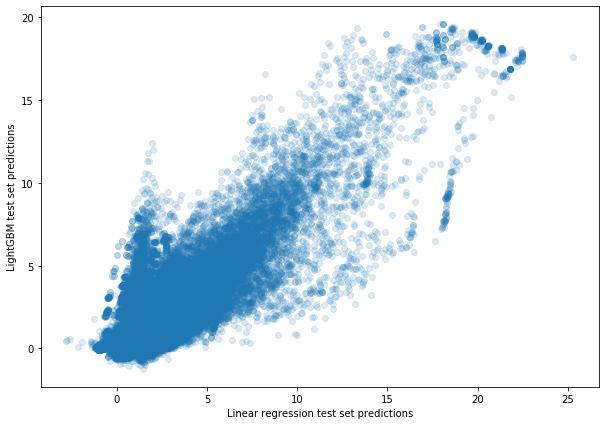

In [20]:
plt.figure(figsize=(10,7))
plt.scatter(X_train_level2[:,0], X_train_level2[:,1], marker='o', alpha=0.15)
plt.xlabel('Linear regression test set predictions')
plt.ylabel('LightGBM test set predictions')
plt.show()

In [21]:
# Stacking both models
y_train_level2 = y_train[dates_train.isin(periods)]
lr_stack = LinearRegression().fit(X_train_level2, y_train_level2)

In [22]:
train_preds = lr_stack.predict(X_train_level2)
rmse_train = np.sqrt(mean_squared_error(y_train_level2, train_preds))

val_preds = lr_stack.predict(X_val_level2)
rmse_val = np.sqrt(mean_squared_error(y_val, val_preds))

print(f"Train RMSE: {rmse_train}\nTest RMSE: {rmse_val}")

Train RMSE: 0.8034767873144171
Test RMSE: 0.9503757466700925


In [23]:
# Creating submission files for each model
y_test_lgbm = model_lgbm.predict(X_test).clip(0, 20)
y_test_linreg = model_linreg.predict(X_test).clip(0, 20)

lgbm_sub = pd.DataFrame({'ID': test.index, 'item_cnt_month': y_test_lgbm})
linreg_sub = pd.DataFrame({'ID': test.index, 'item_cnt_month': y_test_linreg})

lgbm_sub.to_csv("submission_lgbm.csv", index = False)
linreg_sub.to_csv("submission_linreg.csv", index = False)

Used the LGBM for submission and got public and private LB scores as: 0.980493 and 0.983770.